In [109]:
import pandas as pd
import seaborn as sns
blablacar_df = pd.read_csv('data/blablacar.csv', low_memory=False)

# Duplicated drivers

Maybe we should run compared analysis by droping duplicated drivers... Is it influencing stats?

In [73]:
round(100*blablacar_df.driver_id.duplicated().sum()/blablacar_df.shape[0])

14

# Clean data

In [106]:
# create new dataset
df = blablacar_df

# remove useless columns (maybe we could verify driver duplicates, it might influence )
df = df.drop(columns=[
    'trip_id', 
    'driver_id', 
    'city_from', 
    'city_to'
])

# format dates, calculate trip anticipation, remove dates
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df['travel_date'] = pd.to_datetime(df['travel_date'], errors='coerce')
df['anticipation_days'] = df.travel_date - df.publication_date
df.dropna(subset=['anticipation_days'], inplace=True)

df['anticipation'] = 'E(none)'
df.loc[df['anticipation_days'].dt.days>0, 'anticipation'] = 'D(low)'
df.loc[df['anticipation_days'].dt.days>3, 'anticipation'] = 'C(normal)'
df.loc[df['anticipation_days'].dt.days>10, 'anticipation'] = 'B(high)'
df.loc[df['anticipation_days'].dt.days>20, 'anticipation'] = 'A(very high)'

df = df.drop(columns=['publication_date', 'travel_date', 'anticipation_days'])

# calculate price diff, remove other price stuff
df['diff_price_eur'] = df.price_driver_eur - df.price_reco_eur
df = df.drop(columns=['price_reco_adoption', 'price_reco_eur', 'price_driver_eur'])

# is_unbooked : driver failed booking because forgot to accept passenger request ?
#df['is_unbooked'] = df['auto_accept']!=True and df['has_been_cancelled_by_DRVR']!=False and df['seats_booked']>df['seats_requested']

df['reviews'] = 'A(none)'
df.loc[df['driver_no_of_reviews']>0, 'reviews'] = 'B(few)'
df.loc[df['driver_no_of_reviews']>5, 'reviews'] = 'C(some)'
df.loc[df['driver_no_of_reviews']>10, 'reviews'] = 'D(many)'
df.loc[df['driver_no_of_reviews']>20, 'reviews'] = 'E(many +)'
df = df.drop(columns=['driver_no_of_reviews'])


df['diff_price'] = 'C(same)'
df.loc[df['diff_price_eur']<0, 'diff_price'] = 'B(lower)'
df.loc[df['diff_price_eur']<-5, 'diff_price'] = 'A(much lower)'
df.loc[df['diff_price_eur']>0, 'diff_price'] = 'D(higher)'
df.loc[df['diff_price_eur']>5, 'diff_price'] = 'E(much higher)'
df = df.drop(columns=['diff_price_eur'])


# type profile pic column
#df['driver_has_profile_picture'] = df['driver_has_profile_picture'].astype('bool')

df.head()

,distance_km,declared_stopover_count,has_trip_verbatim,offered_seats,auto_accept,seats_requested,seats_booked,seats_confirmed,has_been_cancelled_by_DRVR,driver_has_profile_picture,driver_avg_rating,driver_is_newbie,driver_has_id_check,driver_has_email_verified,is_successful_confirmed,anticipation,reviews,diff_price
1,165,0,True,3,False,0,0,0,False,TRUE,4.7,False,False,True,False,C(normal),E(many +),C(same)
2,75,0,False,4,True,1,1,1,False,TRUE,4.4,False,True,True,True,D(low),E(many +),D(higher)
3,410,0,True,3,False,0,0,0,True,TRUE,4.6,False,True,True,False,C(normal),D(many),D(higher)
4,244,1,False,3,False,4,3,3,False,TRUE,4.8,False,False,True,True,D(low),E(many +),D(higher)
5,622,0,False,1,False,5,0,0,True,TRUE,NaN,False,False,True,False,C(normal),A(none),C(same)


# Compared success rates

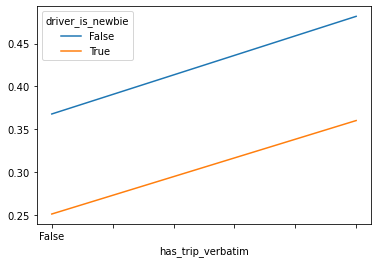

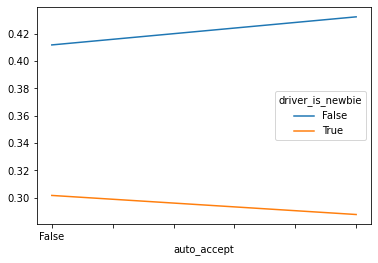

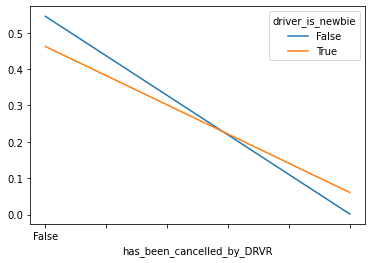

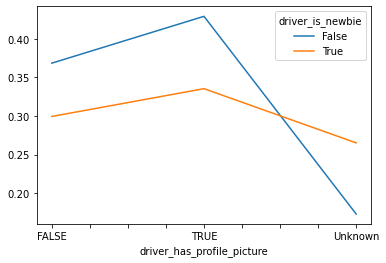

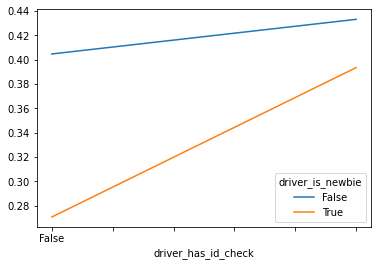

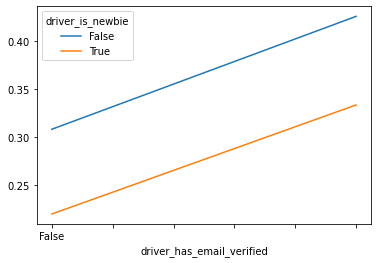

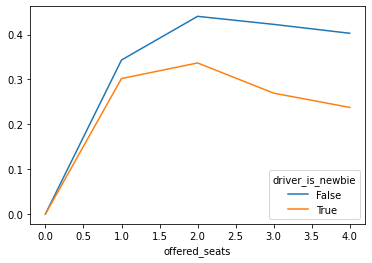

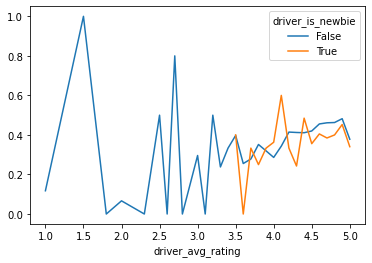

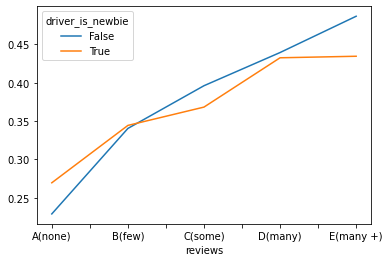

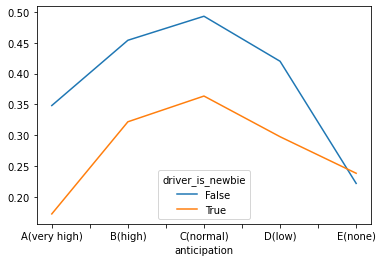

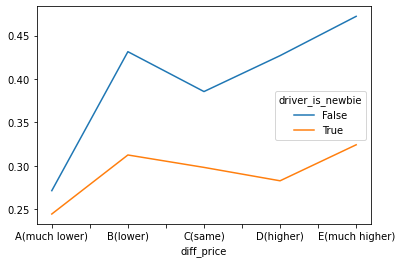

In [108]:
analyzed_values = [
    'has_trip_verbatim',
    'auto_accept',
    'has_been_cancelled_by_DRVR',
    'driver_has_profile_picture',
    'driver_has_id_check',
    'driver_has_email_verified',
    'offered_seats',
    'driver_avg_rating',
    'reviews',
    'anticipation',
    'diff_price'
]
for c in boolean_values:
    pd.pivot_table(df, 
        values='is_successful_confirmed', 
        columns='driver_is_newbie', 
        index=c
    ).plot()

In [110]:
# check unanalyzed stuff
df.drop(columns=boolean_values).head()

,distance_km,declared_stopover_count,seats_requested,seats_booked,seats_confirmed,driver_is_newbie,is_successful_confirmed
1,165,0,0,0,0,False,False
2,75,0,1,1,1,False,True
3,410,0,0,0,0,False,False
4,244,1,4,3,3,False,True
5,622,0,5,0,0,False,False


# Verify pivot table

Just to check that the values given by the `pivot_table` function are indeed the success rate we expect

In [119]:
# success rate for newbies having ID check 

# filter on newbies only
newbies_df = df[df['driver_is_newbie']==True]
# then filter on id check
newbiesidchecked_df = newbies_df[newbies_df['driver_has_id_check']]
# count trips for newbies with id check
total_newbiesidchecked = newbiesidchecked_df.shape[0]
# count trips for newbies with id check AND successful confirmed
total_newbiesidchecked_withsuccess = newbiesidchecked_df[newbiesidchecked_df['is_successful_confirmed']].shape[0]

# display success rate
round(total_newbiesidchecked_withsuccess/total_newbiesidchecked , 6)

0.39358

In [118]:
# verify that what we get in the pivot table are idead success rates (mean on a series of booleans)
pd.pivot_table(df, 
    values='is_successful_confirmed', 
    columns='driver_is_newbie', 
    index='driver_has_id_check'
)

driver_is_newbie,False,True
driver_has_id_check,,
False,0.404786,0.270765
True,0.433249,0.393580


We do get the same value (0.393580).